In [1]:
import pygeos as pg
import matplotlib.pyplot as plt
import numpy as np

from data import load_by_day

In [2]:
def plot_geom(geom, *args, **kwargs):
    xy = pg.get_coordinates(geom)
    plt.plot(xy[:, 0], xy[:, 1], *args, **kwargs)

In [17]:
time, load, solar_pu = load_by_day(0, 365 * 2)
dt = np.diff(time)
assert np.all(np.isclose(dt, dt[0]))
dt = dt[0] / 60

In [18]:
num_E = 3
MWh_per_MW = 4
E_list = np.linspace(800, 1600, num_E)  # MWh
P_list = E_list / MWh_per_MW  # MW
solar_capacity_list = np.linspace(50, 100, 3)  # MW
geothermal_capacity_list = np.linspace(20, 60, 3) # MW 

In [19]:
# technical constraints necessary for projecting 1D interval onto
# 2D space. Infinity doesn't work... 
E_MIN = - np.max(E_list)
E_MAX = 2 * np.max(E_list)
P_MIN = - 2* np.max(P_list)
P_MAX = 2* np.max(P_list)

In [129]:
# PE_grid, solar_grid, geothermal_grid = np.meshgrid([E_list, P_list], solar_capacity_list, geothermal_capacity_list)
# E_grid = PE_grid[:, :num_E, :]
# P_grid = PE_grid[:, num_E:, :]
# PE_grid[0, :, 0]

In [5]:
def control_state_polygon(P, E, dt):
    # Our polygon shape assumes that we can't unload all energy in a single timestep...
    assert P * dt < E
    return pg.polygons(pg.linearrings([
        (0, 0),
        (P, P * dt),
        (P, E),
        (0, E),
        (-P, E - P*dt),
        (-P, 0)
    ]))


def control_constraints(P, E, dt, load, generation):
    # Control constraints as a function of battery state (capacity) and power output.
    U_sys = control_state_polygon(P, E, dt)

    # Control constraints as a function of time-varying load/generation.
    # TODO: How does wind integrate here??
    u_min = np.clip(load - generation, -P, P)
    u_max = np.clip(load, -P, P)

    # load constraints. Assuming
    U_load = pg.box(u_min, E_MIN, u_max, E_MAX)
    # Total control constraints (as a polygon on the 2D control/state space) at each time
    return pg.intersection(U_sys, U_load)

In [6]:
def x_interval(x_min, x_max):
    return pg.box(P_MIN, x_min, P_MAX, x_max)

In [14]:
# Transformation matrix from [u_t, x_t]^T -> [u_t, x_{t+1}]^T
A = np.array([
    [1, -dt],
    [0, 1]
])

def next_reachable_set(X, U):
    x_u_feasible = pg.intersection(X, U)
    x_tp1 = pg.apply(
        x_u_feasible,
        lambda xy: xy @ A
    )
    bounds = pg.bounds(x_tp1)
    return x_interval(bounds[1], bounds[3])
    

In [9]:
import itertools

In [10]:
def reachability(X0, U_t):
    X = [X0]
    # Fold the reachability map over the control inputs U_t
    for U in U_t:
        if X[-1] is None:
            return X
        X.append(next_reachable_set(X[-1], U))
    return np.array(X)

In [15]:
def grid_search(E_list, P_list, solar_list, geothermal_list, load, dt, solar_pu):
    
    it = itertools.product(
        zip(E_list, P_list),
        solar_list,
        geothermal_list
    )

    X_out = {}
    for (E, P), solar_capacity, geothermal_capacity in it:
        print("Computing constraints for:", P, E, solar_capacity, geothermal_capacity)
        U_t = control_constraints(
            P, E, dt,
            load - geothermal_capacity, 
            solar_pu * solar_capacity
        )
        print("Computing reachability")
        X0 = x_interval(0, E)
        X_out[E, P, solar_capacity, geothermal_capacity] = reachability(X0, U_t)
    return X_out

In [16]:
X_out = grid_search(E_list, P_list,
                    solar_capacity_list, geothermal_capacity_list,
                    load, dt, solar_pu)

Computing constraints for: 200.0 800.0 50.0 20.0
Computing reachability
Computing constraints for: 200.0 800.0 50.0 40.0
Computing reachability
Computing constraints for: 200.0 800.0 50.0 60.0
Computing reachability
Computing constraints for: 200.0 800.0 75.0 20.0
Computing reachability


/home/sean/code/study-hard/renewable_energy/venv/lib/python3.8/site-packages/pygeos/set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Computing constraints for: 200.0 800.0 75.0 40.0
Computing reachability
Computing constraints for: 200.0 800.0 75.0 60.0
Computing reachability
Computing constraints for: 200.0 800.0 100.0 20.0
Computing reachability
Computing constraints for: 200.0 800.0 100.0 40.0
Computing reachability
Computing constraints for: 200.0 800.0 100.0 60.0
Computing reachability
Computing constraints for: 300.0 1200.0 50.0 20.0
Computing reachability
Computing constraints for: 300.0 1200.0 50.0 40.0
Computing reachability
Computing constraints for: 300.0 1200.0 50.0 60.0
Computing reachability
Computing constraints for: 300.0 1200.0 75.0 20.0
Computing reachability
Computing constraints for: 300.0 1200.0 75.0 40.0
Computing reachability
Computing constraints for: 300.0 1200.0 75.0 60.0
Computing reachability
Computing constraints for: 300.0 1200.0 100.0 20.0
Computing reachability
Computing constraints for: 300.0 1200.0 100.0 40.0
Computing reachability
Computing constraints for: 300.0 1200.0 100.0 60.0


In [23]:
help(np.vectorize)

Help on class vectorize in module numpy:

class vectorize(builtins.object)
 |  vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False, signature=None)
 |  
 |  vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False,
 |            signature=None)
 |  
 |  Generalized function class.
 |  
 |  Define a vectorized function which takes a nested sequence of objects or
 |  numpy arrays as inputs and returns a single numpy array or a tuple of numpy
 |  arrays. The vectorized function evaluates `pyfunc` over successive tuples
 |  of the input arrays like the python map function, except it uses the
 |  broadcasting rules of numpy.
 |  
 |  The data type of the output of `vectorized` is determined by calling
 |  the function with the first element of the input.  This can be avoided
 |  by specifying the `otypes` argument.
 |  
 |  Parameters
 |  ----------
 |  pyfunc : callable
 |      A python function or method.
 |  otypes : str or list of dtypes, optional
 |      The 

In [ ]:
# want 

In [28]:
time.shape

(105408,)

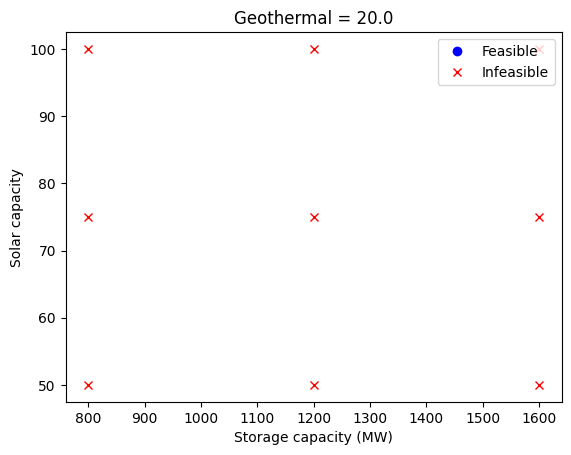

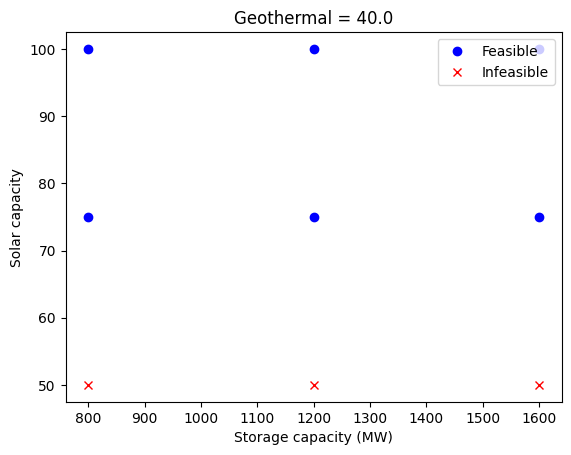

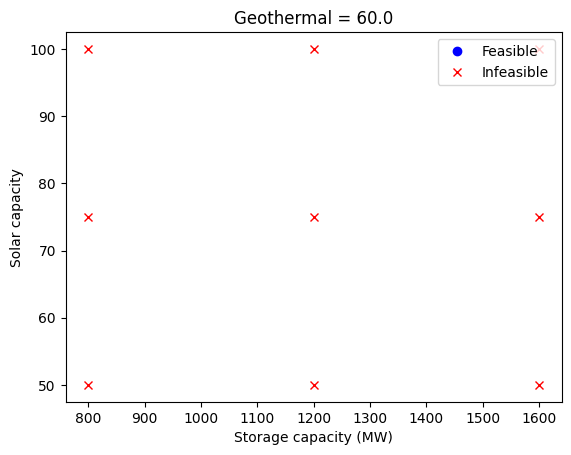

In [94]:

for geo in geothermal_capacity_list:
    E_sol, P_sol, solar_sol = zip(*[
        (E, P, s) for ((E, P), s)in itertools.product(
        zip(E_list, P_list),
        solar_capacity_list,
    #     geothermal_capacity_list
    )])
    feasible = []
    days = []
    for E, P, solar in zip(E_sol, P_sol, solar_sol):
        X = X_out[E, P, solar, geo]
        feasible.append(
            X[-1] is not None
        )
        first_empty_index = None
        for i, X_i in enumerate(X):
            if X_i is None:
                first_empty_index = i
                break
        if first_empty_index is None:
            days.append(365)
        else:
            days.append(time[first_empty_index] / 60 / 24)
#         print("E P solar geo", E, P, solar, geo)
#         print("Feasible:", feasible[-1])
#         if not feasible[-1]:
#             print("Time of first empty set (days):", days[-1])
    E_feas = [E for E, feasible in zip(E_sol, feasible) if feasible]
    E_infeas = [E for E, feasible in zip(E_sol, feasible) if not feasible]
    
    solar_feas = [s for s, feasible in zip(solar_sol, feasible) if feasible]
    solar_infeas = [s for s, feasible in zip(solar_sol, feasible) if not feasible]
#     _, plots = plt.subplots(1, 2, sharex=True, sharey=True)
    plt.figure()
    plt.title(f"Geothermal = {geo}")
    plt.plot(E_feas, solar_feas, 'bo', label="Feasible")
    plt.plot(E_infeas, solar_infeas, 'rx', label="Infeasible")
    plt.xlabel("Storage capacity (MW)")
    plt.ylabel("Solar capacity")
    plt.legend()
#     plt.plot(E, P)
        
#     for (E, P), solar in it:
#         print(E, P, solar, geo)
#         print((E, P, solar, geo) in X_out)
#     EP, solar = np.meshgrid([E_list, P_list], solar_capacity_list)
#     E = EP[:, :num_E]
#     P = EP[:, num_E:]
#     print(geothermal)
#     print(P.shape)
#     print(E)



In [64]:
for x_i in X:
    if pg.is_empty(x_i):
        print('empty')
    if not isinstance(x_i, pg.Geometry) and x_i is not None:
        print(type(x_i))
#     if not isinstance(x_i)
#     print(x_i)

In [59]:
X

array([<pygeos.Geometry POLYGON ((800 0, 800 1600, -800 1600, -800 0, 800 0))>,
       <pygeos.Geometry POLYGON ((800 1.871, 800 1600, -800 1600, -800 1.871, 800 1...>,
       <pygeos.Geometry POLYGON ((800 3.757, 800 1600, -800 1600, -800 3.757, 800 3...>,
       ..., None, None, None], dtype=object)

In [ ]:
X0 = x_interval(0, E)
X = reachability(X0, U_t)

In [27]:
def plot_reachable_capacity(X, title):
    X_bounds = pg.bounds(X)
    X_min = X_bounds[:, 1]
    X_max = X_bounds[:, 3]
    min_to_day = 60 * 24
    _, plots = plt.subplots(2, 1, sharex=True)
    plt.suptitle(f"Feasible battery charge over time\n{title}")
    plots[0].plot(time / min_to_day, X_max[:-1], label="Maximum possible battery charge")
    plots[0].set_ylabel("Storage (MWh)")
    plots[1].plot(time / min_to_day, X_min[:-1], label="Minimum possible battery charge")
    plots[1].set_xlabel("Time (days)")
    plots[1].set_ylabel("Storage (MWh)")
    for p in plots:
        p.legend()
    

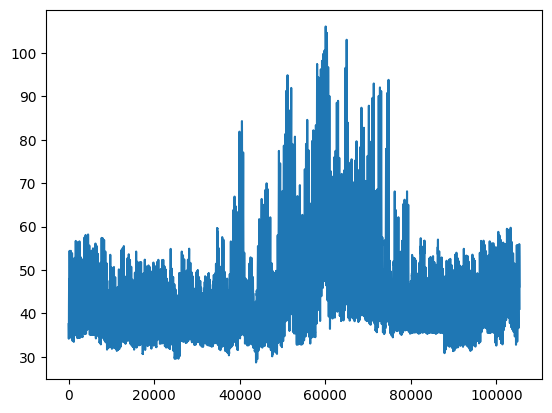

In [119]:
plt.plot(load)

E P s g 1200.0 300.0 50.0 60.0


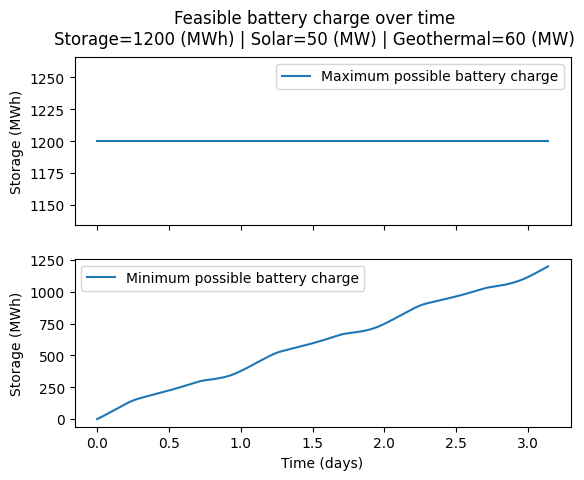

In [118]:
e_index = 1
E = E_list[e_index]
P = P_list[e_index]
s = solar_capacity_list[0]
g = geothermal_capacity_list[2]
print("E P s g", E, P, s, g)
title = (
    f"Storage={int(E)} (MWh) | "
    f"Solar={int(s)} (MW) | Geothermal={int(g)} (MW)"
)
X = X_out[E, P, s, g]
plot_reachable_capacity(X, title)

In [46]:
pg.is_empty(X[-1])

False

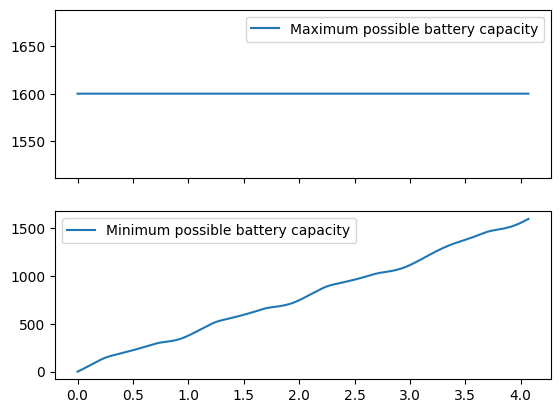

In [ ]:
plt.figure()
plot_geom(U_sys, label="U_SYS")
plot_geom(u_t_total, label="U_t")
plt.legend()

In [ ]:
x_tp1_bounds

In [ ]:
plt.figure()
plot_geom(x_tp1)

In [33]:
E = 1000  # MWh
# Maximum (dis)charge capacity of battery
P = 400  # MW
solar_capacity = 100  # MW
geothermal_capacity = 40  # MW

In [34]:
U_t = control_constraints(
    P, E, dt,
    load, 
    solar_pu * solar_capacity +  geothermal_capacity
)

In [35]:
X0 = x_interval(0, E)
X = reachability(X0, U_t)

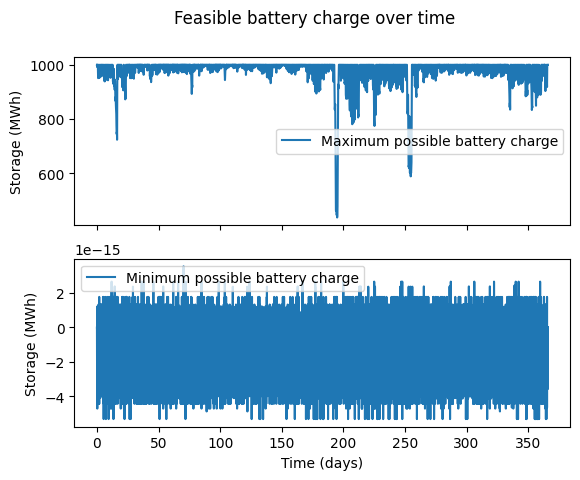

In [36]:
plot_reachable_capacity(X, "")